In [2]:
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP
from utils.preprocessing import split,Normalize

In [3]:

def plot_results(network):
    train_pred = network.predict(input_data)
    val_pred = network.predict(val_data)
    x = np.arange(len(network.train_MEE))

    fig = plt.figure(figsize=(13,4))

    fig.add_subplot(131)
    plt.plot(x,network.train_MEE)
    plt.plot(x,network.val_MEE,label="test")
    plt.title("Learning curve")
    plt.xlabel("Epochs")
    plt.ylabel("Squared error")
    plt.yscale("log")
    plt.legend()

    fig.add_subplot(132)
    plt.title('Residual for training data')
    plt.plot(np.arange(len(labels)),labels[:,0]-train_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(labels)),labels[:,1]-train_pred[:,1],".",label="residual1")
    plt.legend()

    fig.add_subplot(133)
    plt.title('Residual for validation data')
    plt.plot(np.arange(len(val_labels)),val_labels[:,0]-val_pred[:,0],".",label="residual0")
    plt.plot(np.arange(len(val_labels)),val_labels[:,1]-val_pred[:,1],".",label="residual1")
    plt.legend()
    plt.tight_layout()
    plt.show()
    netw.predict(input_data)


In [170]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
np.random.shuffle(raw_data)
other_output=raw_data[:,10]
lin_output=raw_data[:,11]
raw_data=np.delete(raw_data,10,axis=1)


#raw_normalizer=Normalize()
#raw_data=raw_normalizer.normalize(raw_data)

In [5]:

frac_test=0.15
data, test_set=split(raw_data,kind="hold_out",frac_training=1-frac_test)

frac_training=0.8
training,validation=split(data,kind="hold_out",frac_training=frac_training)

input_data=training[:,1:-2]
labels=training[:,-2:]
val_data=validation[:,1:-2]
val_labels=validation[:,-2:]

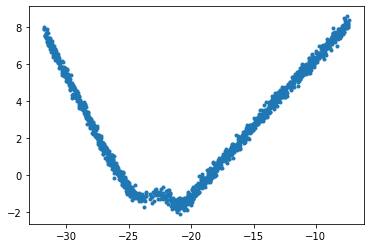

In [11]:
plt.plot(raw_data[:,10],other_output,".")

In [141]:
from scipy.optimize import curve_fit
def f(x,m1,m2,b1,b2,mu,sigma,a,c,start,stop):
    return np.heaviside(start-x,0)*(m1*x+b1)+np.heaviside(x-start,0)*np.heaviside(stop-x,0)*(a*np.exp(-(x-mu)**2/(2*sigma**2))+c)+np.heaviside(x-stop,0)*(m2*x+b2)


In [169]:
initial=np.array([-1.2,0.75,-30.8,14,-22.5,1,0.7,-1.6,-24.5,-20.5])
bound=np.array([1,1,20,20,1.5,2,3,1,3,3])
popt,pcov=curve_fit(f,raw_data[:,10],other_output,
                    p0=initial,bounds=(initial-bound,initial+bound))

RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

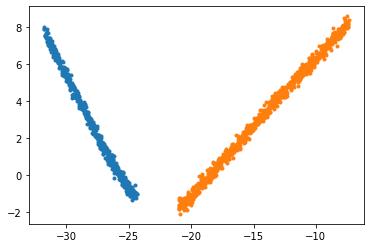

In [189]:
x=np.linspace(-30,-10,100)
mask=lin_output<-24.3
mask2=lin_output>-21.
plt.plot(lin_output[mask],other_output[mask],".",
         lin_output[mask2],other_output[mask2],".")

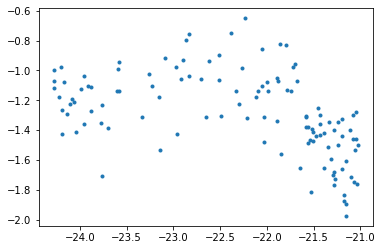

In [200]:
mask3=np.all([lin_output<-21,lin_output>-24.3],axis=0)
plt.plot(lin_output[mask3],other_output[mask3],".")

In [209]:
def linear(x,a,b):
    return a*x+b
def gaussian(x,mu,sigma,a,c):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))+c
def parabola(x,a,b,c):
    return a*x**2+b*x+c

popt1,pcov1=curve_fit(linear,lin_output[mask],other_output[mask])
popt2,pcov2=curve_fit(linear,lin_output[mask2],other_output[mask2])
popt3,pcov3=curve_fit(parabola,lin_output[mask3],other_output[mask3])

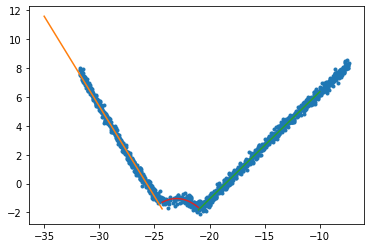

In [214]:
#-21,-24.3
x1=np.linspace(-35,-24.3,100)
x3=np.linspace(-24.3,-21,100)
x2=np.linspace(-21,-10,100)
plt.plot(lin_output,other_output,".")
plt.plot(x1,linear(x1,*popt1),"-",label="linear")
plt.plot(x2,linear(x2,*popt2),"-",label="linear")
plt.plot(x3,parabola(x3,*popt3),"-",label="gaussian")
